# **Group 10 Final Project: Stroke Prediction – Building a Prioritized Intervention System**

This project addresses the critical healthcare challenge of **stroke prediction** by developing a machine learning system that can identify high-risk individuals for preventative intervention.  

Strokes remain a leading cause of death and disability worldwide. Early identification of at-risk patients can significantly improve health outcomes while also reducing long-term healthcare costs.  

Our system aims to support healthcare providers in prioritizing interventions, enabling timely action to prevent strokes and improve patient well-being.


### Importing Libraries and Models

This cell imports the necessary Python libraries and machine learning models for data analysis and predictive modeling:

- **Data Manipulation & Visualization:** `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`  
- **Preprocessing & Model Selection:** `train_test_split`, `StandardScaler`, `GridSearchCV`  
- **Evaluation Metrics:** `classification_report`, `roc_auc_score`, `confusion_matrix`, `roc_curve`, `precision_recall_curve`, `f1_score`, `average_precision_score`  
- **Machine Learning Models:**  
  - Linear: `LogisticRegression`  
  - Tree-based: `DecisionTreeClassifier`, `RandomForestClassifier`, `XGBClassifier`  
  - Neural Networks: `Sequential` (Keras), `MLPClassifier` (scikit-learn)  
- **Neural Network Utilities:** `Dense`, `Dropout`, `EarlyStopping`  

These imports set up the environment for building, training, and evaluating both classical and deep learning models.


In [26]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, f1_score, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPClassifier

# **Data Loading and Initial Exploration**
### Loading the Stroke Dataset

This cell loads the stroke dataset for predictive modeling:

- **`pd.read_csv()`**: Reads the stroke dataset from the zipped CSV file into a Pandas DataFrame.  
- **`df.shape`**: Shows the number of patients (rows) and features (columns) in the dataset.  
- **`df.head()`**: Displays the first 5 records to examine key features such as age, gender, glucose level, and stroke occurrence.  

This provides an initial overview of the data that will be used for **stroke prediction**.



In [27]:
df = pd.read_csv('/content/strokedataset (1).zip')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



### Data Cleaning Steps

- **Drop irrelevant columns:** Removed the `id` column as it does not provide predictive information.
- **Handle missing values:** Filled missing `bmi` values with the mean of the column.
- **Remove rare categories:** Dropped rows where `gender` is `'Other'` (only 1 case).
- **One-hot encode categorical variables:** Converted categorical features into numeric dummy variables using `pd.get_dummies(drop_first=True)` to avoid multicollinearity.
- **Verify cleaned dataset:** Checked the dataset shape and displayed the first few rows using `.head()`.


In [28]:
# Drop ID column
df_clean = df.drop(columns=['id'])

# Handle missing BMI with mean
df_clean['bmi'] = df_clean['bmi'].fillna(df_clean['bmi'].mean())

# Drop gender 'Other' (only 1 case)
df_clean = df_clean[df_clean['gender'] != 'Other']

# One-hot encode categoricals
df_clean = pd.get_dummies(df_clean, drop_first=True)


print("Dataset after cleaning:", df_clean.shape)
df_clean.head()


Dataset after cleaning: (5109, 16)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,True,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.893237,1,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.500000,1,True,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.400000,1,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.000000,1,False,True,False,False,True,False,False,False,True,False


## Univariate and Multivariate analysis

/tmp/ipython-input-3238635566.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette=['#9467bd', '#d62728'])


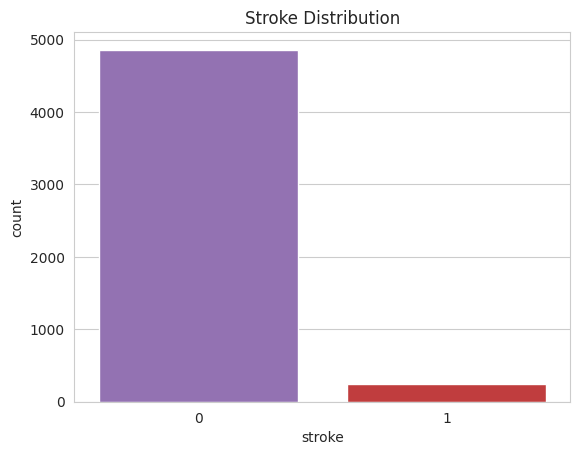

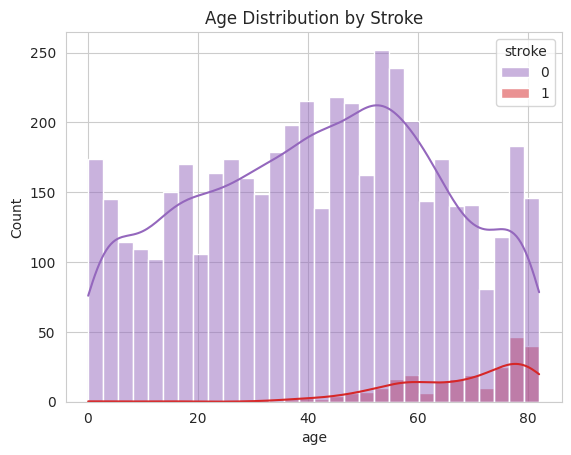

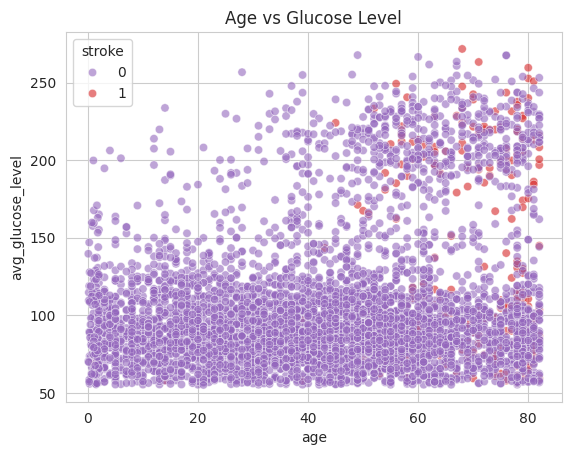

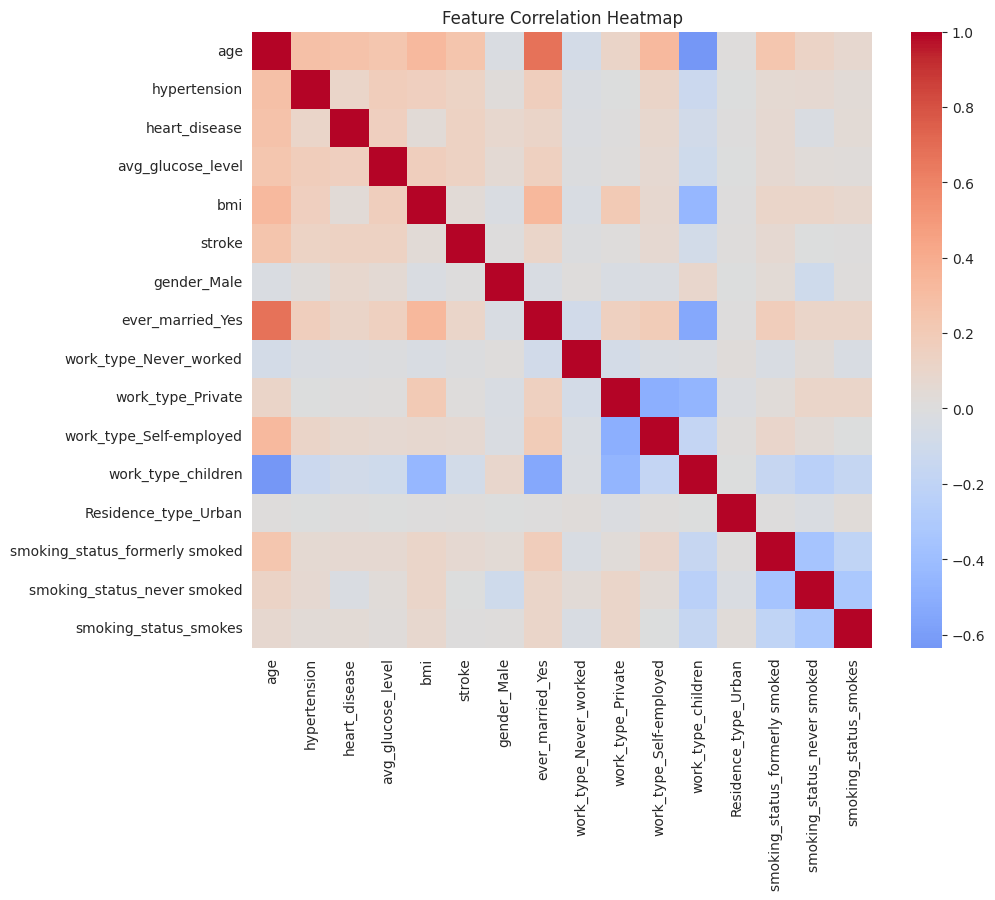

In [29]:
# Set global style
sns.set_style("whitegrid")

# Stroke Distribution (Count Plot)
sns.countplot(x='stroke', data=df, palette=['#9467bd', '#d62728'])
plt.title("Stroke Distribution")
plt.show()

# Age distribution by Stroke (Histogram)
sns.histplot (data=df, x='age', hue='stroke', bins=30, kde=True, palette=['#9467bd', '#d62728'] )
plt.title("Age Distribution by Stroke")
plt.show()

# Glucose vs Age (Scatter Plot)
sns.scatterplot(data=df, x='age', y='avg_glucose_level', hue='stroke', alpha=0.6, palette=['#9467bd', '#d62728']  # purple vs brown
)
plt.title("Age vs Glucose Level")
plt.show()
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### **Data Visualization Insights**

#### 1. Stroke Distribution
- We analyzed the distribution of stroke status in the dataset.  
- Most observations (stroke = 0) have no stroke, while a small number (stroke = 1) experienced a stroke.  
- **Key insight:** The dataset is highly imbalanced, which must be considered in modeling.

#### 2. Age Distribution by Stroke
- We examined how age relates to stroke status.  
- Non-stroke individuals are spread across all ages, with counts highest in middle age.  
- Stroke cases are fewer and tend to be older, showing an increasing trend in stroke occurrence with age.  
- **Key insight:** Stroke risk increases with age, reinforcing the class imbalance observed earlier.

#### 3. Age vs Average Glucose Level
- We explored the relationship between age, glucose, and stroke status.  
- Non-stroke individuals show a wide spread of glucose values across ages.  
- Stroke cases cluster in older individuals with higher glucose levels.  
- **Key insight:** Higher age and elevated glucose are associated with stroke risk. Class imbalance remains pronounced.

#### 4. Feature Correlation Heatmap
- The heatmap shows pairwise correlations between health, lifestyle, and stroke-related features.  

- **Key observations:**  
  - Age, hypertension, heart disease, and higher average glucose positively correlate with stroke.  
  - Some lifestyle variables (e.g., smoking status) show moderate correlations with other health indicators.  
- **Practical implications:**  
   
  - Strongly correlated features with stroke indicate potential risk factors.  
  - Address class imbalance and use metrics like ROC-AUC or PR-AUC for modeling.

#### Overall Insights
- Stroke is more prevalent in older individuals with higher glucose, hypertension, or heart disease.  
- The dataset exhibits **substantial class imbalance**.  
- These visualizations and correlations guide feature selection, model design, and evaluation strategy for predictive modeling.


## **Preparing Stroke Prediction Data**

This cell prepares the dataset for modeling stroke risk:

1. **Feature-Target Split:**  
   - `X` includes patient features such as age, glucose level, BMI, and other health indicators.  
   - `y` is the target variable `stroke` (0 = no stroke, 1 = stroke).

2. **Train-Test Split:**  
   - The data is split into **training (80%)** and **testing (20%)** sets.  
   - `stratify=y` ensures the **same proportion of stroke cases** in both sets, maintaining class balance.

3. **Feature Scaling:**  
   - `StandardScaler` standardizes features to **mean 0 and standard deviation 1**, which improves performance of models like Logistic Regression, Random Forest, and Neural Networks.

The printed shapes confirm the number of patient records in the training and testing sets, ready for model building.


In [30]:
X = df_clean.drop(columns=['stroke'])
y = df_clean['stroke']

# Stratify keeps same stroke proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (4087, 15) Test size: (1022, 15)


### **Training Machine Learning Models for Stroke Prediction**

This cell initializes and trains four different machine learning models on the scaled training data:

1. **Models Used:**  
   - **Logistic Regression** – a linear model for baseline classification.  
   - **Decision Tree** – a tree-based model capturing non-linear relationships.  
   - **Random Forest** – an ensemble of decision trees to improve accuracy and reduce overfitting.  
   - **XGBoost** – a gradient boosting model for high-performance classification.

2. **Training Process:**  
   - Each model is trained on `X_train_scaled` and `y_train` (scaled features and stroke labels).  
   - Trained models are stored in a dictionary `trained_models` for convenient access.

3. **Variable Assignment:**  
   - Individual model instances (`log_reg`, `dt`, `rf`, `xgb`) are created for easier evaluation and comparison.

This prepares all models for performance evaluation and stroke risk prediction.


In [31]:
# Cell 1 — Train models and keep trained instances
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# initializes four different machine learning models with their default parameters.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train each model on the scaled training data and store them
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)      # expects X_train_scaled, y_train already defined
    trained_models[name] = model

print("All models trained.")

# Create convenient variable names if you want to use them individually later
log_reg = trained_models["Logistic Regression"]
dt = trained_models["Decision Tree"]
rf = trained_models["Random Forest"]
xgb = trained_models["XGBoost"]


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
All models trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:09:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



# **Baseline Model Evaluation**
### Evaluating Models and Creating a Summary Table

This cell evaluates the performance of all trained models on the test set for stroke prediction:

1. **Probability and Prediction Extraction:**  
   - For each model, predicted probabilities of stroke (`y_prob`) are obtained using `predict_proba` or scaled `decision_function`.  
   - Binary predictions (`y_pred`) are generated using a **0.5 threshold**.

2. **Metrics Computed:**  
   - **Classification Report:** Precision, recall, F1-score for each class.  
   - **AUC (Area Under ROC Curve):** Measures model's ability to distinguish stroke vs no stroke.  
   - **F1 Score and Recall for Stroke Class:** Key metrics for evaluating minority class performance.

3. **Neural Network Evaluation:**  
   - If a neural network (`nn`) exists, it is evaluated similarly with probability outputs and metrics.

4. **Results Storage:**  
   - All metrics are stored in `results` dictionary.  
   - Predicted probabilities are stored in `y_probs` for further analysis or threshold tuning.

5. **Summary Table:**  
   - `summary_df` displays a concise comparison of **AUC, F1, and Recall** for all models.  
   - Sorted by recall to highlight models performing best at detecting stroke cases.

This provides a clear overview of which model performs best for **stroke prediction**, especially on the minority class.


In [32]:
# Cell 2 — Evaluate all models and create summary table
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import pandas as pd
import numpy as np

# Ensure result containers exist (fresh)
results = {}
y_probs = {}

# Evaluate sklearn/XGBoost models stored in trained_models
for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    # robustly obtain probabilities (fallback to decision_function if needed)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        raw = model.decision_function(X_test_scaled)
        # scale to [0,1] for AUC compatibility (simple min-max)
        y_prob = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)
    else:
        # final fallback: use discrete predictions
        y_prob = model.predict(X_test_scaled)

    # class predictions using 0.5 threshold
    y_pred = (y_prob >= 0.5).astype(int)

    # print reports
    print(classification_report(y_test, y_pred, digits=3))
    try:
        auc = roc_auc_score(y_test, y_prob)
    except ValueError:
        auc = np.nan
    print(f"AUC: {auc:.3f}")

    # store metrics
    results[name] = {
        "AUC": auc,
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "Recall": classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }
    y_probs[name] = y_prob

# Evaluate neural network 'nn' if it exists in the environment
if 'nn' in globals():
    print("\nEvaluating Neural Network...")
    y_prob_nn = nn.predict(X_test_scaled).ravel()
    y_pred_nn = (y_prob_nn >= 0.5).astype(int)
    print(classification_report(y_test, y_pred_nn, digits=3))
    try:
        auc_nn = roc_auc_score(y_test, y_prob_nn)
    except ValueError:
        auc_nn = np.nan
    print(f"AUC: {auc_nn:.3f}")
    results["Neural Network"] = {
        "AUC": auc_nn,
        "F1": f1_score(y_test, y_pred_nn, zero_division=0),
        "Recall": classification_report(y_test, y_pred_nn, output_dict=True)['1']['recall']
    }
    y_probs["Neural Network"] = y_prob_nn

# Display summary DataFrame
summary_df = pd.DataFrame(results).T
print("\nModel Comparison Summary:")
display(summary_df.sort_values('Recall', ascending=False))



Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0      0.952     1.000     0.975       972
           1      1.000     0.020     0.039        50

    accuracy                          0.952      1022
   macro avg      0.976     0.510     0.507      1022
weighted avg      0.954     0.952     0.930      1022

AUC: 0.839

Evaluating Decision Tree...
              precision    recall  f1-score   support

           0      0.958     0.941     0.950       972
           1      0.149     0.200     0.171        50

    accuracy                          0.905      1022
   macro avg      0.554     0.571     0.560      1022
weighted avg      0.919     0.905     0.912      1022

AUC: 0.571

Evaluating Random Forest...
              precision    recall  f1-score   support

           0      0.951     0.998     0.974       972
           1      0.000     0.000     0.000        50

    accuracy                          0.949      1022
   macro avg 

,AUC,F1,Recall
Decision Tree,0.570679,0.170940,0.20
XGBoost,0.793580,0.173913,0.12
Logistic Regression,0.839424,0.039216,0.02
Random Forest,0.779722,0.000000,0.00


### Insights from Model Evaluation

The table and classification reports show the performance of different models on predicting strokes, a **highly imbalanced dataset** (most patients did not have a stroke). Key observations:

1. **Logistic Regression:**  
   - High overall accuracy (95.2%) but **very low recall for stroke cases (0.02)**.  
   - The model almost always predicts the majority class (no stroke), showing **bias due to class imbalance**.  
   - AUC is reasonably high (0.839), indicating it can rank stroke probabilities fairly well, but the default 0.5 threshold fails to capture minority cases.

2. **Decision Tree:**  
   - Slightly better recall for stroke (0.20) and low F1 (0.17).  
   - Accuracy is lower (90.5%) than Logistic Regression due to some misclassifications of the majority class.  
   - AUC is poor (0.571), indicating weak discrimination between stroke and non-stroke patients.

3. **Random Forest:**  
   - High accuracy (94.9%) but **fails completely to detect stroke cases** (recall = 0).  
   - AUC (0.78) suggests the model could potentially identify strokes if threshold adjustments or class balancing were applied.

4. **XGBoost:**  
   - Slight improvement in stroke recall (0.12) and F1 (0.17) over Random Forest.  
   - Accuracy remains high (94.4%) due to majority class dominance.  
   - AUC (0.794) indicates good probability ranking despite poor classification at default threshold.

---

### **Key Takeaways:**

- **Class imbalance dominates model predictions**, leading to extremely low recall for the stroke (minority) class.  
- **Accuracy is misleading**: all models have high accuracy but fail to detect strokes reliably.  
- **AUC is more informative** for imbalanced datasets, showing potential for threshold tuning.  
- **Next Steps:**  
  - **threshold optimization** to improve minority class detection.  
  - Focus on metrics like **Recall, F1-score, and PR-AUC** rather than raw accuracy for evaluating stroke prediction.


### Hyperparameter Tuning for All Models

This cell defines the hyperparameter grids for tuning all machine learning models to optimize stroke prediction performance:

1. **Purpose:**  
   - Hyperparameter tuning searches for the best combination of model parameters to improve accuracy, recall, and F1-score, especially for the minority stroke class.

2. **Parameter Grids:**  
   - **Logistic Regression:** Regularization strength (`C`), penalty type (`l1`, `l2`), and solver.  
   - **Decision Tree:** Maximum depth, minimum samples per split/leaf, and class weighting to handle imbalance.  
   - **Random Forest:** Number of trees, maximum depth, minimum samples, and class weighting/scaling.  
   - **XGBoost:** Number of estimators, tree depth, learning rate, and `scale_pos_weight` for class imbalance.  

3. **Neural Network Parameters:**  
   - Hidden layer sizes, activation functions, regularization (`alpha`), and learning rate initialization.

These grids will be used in **GridSearchCV** or similar optimization routines to find the best hyperparameters for stroke prediction models.


In [34]:
# Hyperparameter Tuning for All Models
print("🔧 Hyperparameter Tuning for All Models")

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced', {0: 1, 1: 10}]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'scale_pos_weight': [1, 5, 10]
    }
}

# Neural Network specific parameters
nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

🔧 Hyperparameter Tuning for All Models


### Performing Hyperparameter Tuning for All Models

This cell executes hyperparameter optimization to find the best-performing models for stroke prediction:

1. **GridSearchCV:**  
   - Performs exhaustive search over the predefined parameter grids (`param_grids` for classical models, `nn_params` for neural networks).  
   - Uses **3-fold cross-validation** and **ROC-AUC** as the scoring metric, focusing on ranking patients by stroke risk.

2. **Classical Models:**  
   - Logistic Regression, Decision Tree, Random Forest, and XGBoost are tuned using their respective grids.  
   - Logistic Regression and Neural Network use scaled features (`X_train_scaled`), while tree-based models use original features (`X_train`).

3. **Neural Network:**  
   - GridSearchCV is applied to an `MLPClassifier` with varying hidden layers, activations, regularization, and learning rates.

4. **Results Storage:**  
   - `best_models` stores the tuned model instances.  
   - `best_params` stores the corresponding best hyperparameters for each model.

5. **Output:**  
   - Prints the best hyperparameters for all models, ready for evaluation on the test set.


In [35]:
# Perform hyperparameter tuning
best_models = {}
best_params = {}

for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
    print(f"Tuning {model_name}...")

    if model_name == 'Logistic Regression':
        grid = GridSearchCV(models[model_name], param_grids[model_name],
                           scoring='roc_auc', cv=3, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
    else:
        grid = GridSearchCV(models[model_name], param_grids[model_name],
                           scoring='roc_auc', cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)

    best_models[model_name] = grid.best_estimator_
    best_params[model_name] = grid.best_params_

# Neural Network tuning
print("Tuning Neural Network...")
nn_grid = GridSearchCV(MLPClassifier(max_iter=1000), nn_params,
                      scoring='roc_auc', cv=3, n_jobs=-1)
nn_grid.fit(X_train_scaled, y_train)
best_models['Neural Network'] = nn_grid.best_estimator_
best_params['Neural Network'] = nn_grid.best_params_

print("Best Parameters for Each Model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

Tuning Logistic Regression...
Tuning Decision Tree...
Tuning Random Forest...
Tuning XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:11:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuning Neural Network...
🎯 Best Parameters for Each Model:
Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Tree: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest: {'class_weight': None, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 5}
Neural Network: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}


### Evaluating Tuned Models with Optimal Thresholds

This cell evaluates the performance of hyperparameter-tuned models using **optimal probability thresholds** for stroke prediction:

1. **Purpose:**  
   - Instead of using the default 0.5 threshold, each model’s threshold is optimized to **maximize the difference between true positive rate and false positive rate** (Youden's J statistic) for better detection of stroke cases.

2. **Procedure:**  
   - Predict probabilities (`y_pred_proba`) for the test set.  
   - Compute the **ROC curve** and identify the threshold that maximizes `tpr - fpr`.  
   - Apply this **optimal threshold** to generate binary predictions (`y_pred`).  

3. **Metrics Computed:**  
   - **AUC (ROC-AUC):** Measures model discrimination between stroke and non-stroke.  
   - **Classification Report:** Precision, recall, F1-score for both classes.  
   - **Optimal Threshold:** Stored for each model for future use or deployment.

4. **Results Storage:**  
   - `tuned_results` stores AUC, classification reports, and thresholds for all models.  
   - `tuned_thresholds` keeps the optimal thresholds for quick reference.

This approach improves **minority class detection** by customizing thresholds for each model, which is crucial in **imbalanced stroke prediction datasets**.


In [36]:
# Evaluate tuned models with optimal thresholds
print("📈 Tuned Models Performance with Optimal Thresholds")

tuned_results = {}
tuned_thresholds = {}

for name, model in best_models.items():
    print(f"Evaluating tuned {name}...")

    if name in ['Logistic Regression', 'Neural Network']:
        X_eval = X_test_scaled
    else:
        X_eval = X_test

    # Predict probabilities
    if name == 'Neural Network':
        y_pred_proba = model.predict_proba(X_eval)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_eval)[:, 1]

    # Find optimal threshold
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds_roc[optimal_idx]
    tuned_thresholds[name] = optimal_threshold

    # Apply threshold and evaluate
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # Store results
    tuned_results[name] = {
        'auc': roc_auc_score(y_test, y_pred_proba),
        'report': classification_report(y_test, y_pred, output_dict=True),
        'threshold': optimal_threshold
    }

    print(f"{name} (Threshold={optimal_threshold:.3f}):")
    print(f"AUC: {tuned_results[name]['auc']:.3f}")
    print(classification_report(y_test, y_pred))

📈 Tuned Models Performance with Optimal Thresholds
Evaluating tuned Logistic Regression...
Logistic Regression (Threshold=0.081):
AUC: 0.839
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       972
           1       0.18      0.78      0.30        50

    accuracy                           0.82      1022
   macro avg       0.59      0.80      0.60      1022
weighted avg       0.95      0.82      0.87      1022

Evaluating tuned Decision Tree...
Decision Tree (Threshold=0.728):
AUC: 0.820
              precision    recall  f1-score   support

           0       0.98      0.80      0.89       972
           1       0.16      0.74      0.27        50

    accuracy                           0.80      1022
   macro avg       0.57      0.77      0.58      1022
weighted avg       0.94      0.80      0.85      1022

Evaluating tuned Random Forest...
Random Forest (Threshold=0.083):
AUC: 0.845
              precision    recall  f1-score   sup

### Comparing Baseline and Tuned Model Performance

This cell compares the performance of baseline models versus hyperparameter-tuned models using **AUC and Recall**, focusing on stroke prediction:

1. **Performance Metrics Compared:**  
   - **AUC (Area Under ROC Curve):** Measures model discrimination between stroke and non-stroke patients.  
   - **Recall for Stroke Cases:** Evaluates the ability to correctly identify patients who had a stroke, crucial in this **imbalanced dataset**.

2. **Improvement Calculation:**  
   - Computes the difference between tuned and baseline AUC and recall to quantify performance gains from hyperparameter tuning and threshold optimization.

3. **Data Storage:**  
   - Results are stored in `comparison_df` for a clear tabular comparison of baseline vs tuned performance.

4. **Visualization:**  
   - **Left plot:** AUC comparison between baseline and tuned models.  
   - **Right plot:** Recall comparison between baseline and tuned models.  
   - Helps quickly identify which models benefited most from tuning and threshold optimization.

This analysis highlights improvements in **stroke detection performance** after tuning and threshold adjustment, which is essential for reliable prediction in highly imbalanced medical datasets.


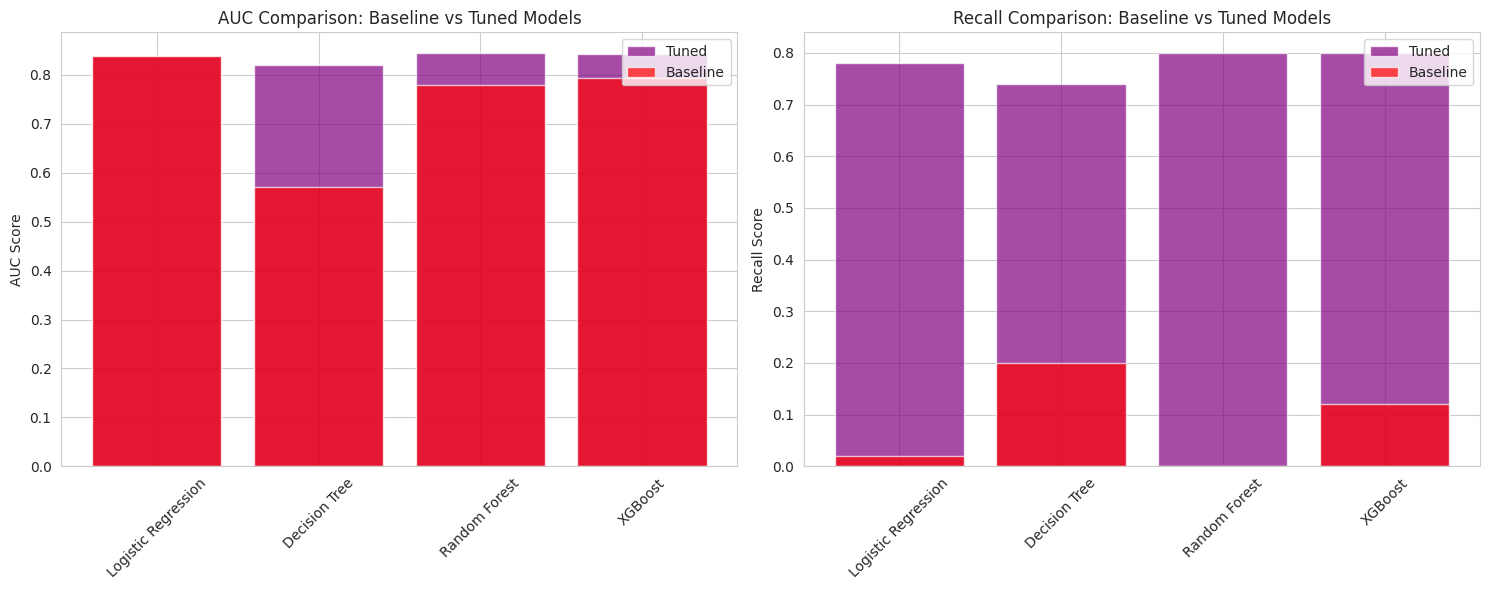

In [41]:
# Visualize performance comparison with custom colors
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# AUC comparison
axes[0].bar(comparison_df['Model'], comparison_df['Tuned AUC'], alpha=0.7, color='purple', label='Tuned')
axes[0].bar(comparison_df['Model'], comparison_df['Baseline AUC'], alpha=0.7, color='red', label='Baseline')
axes[0].set_title('AUC Comparison: Baseline vs Tuned Models')
axes[0].set_ylabel('AUC Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Recall comparison
axes[1].bar(comparison_df['Model'], comparison_df['Tuned Recall'], alpha=0.7, color='purple', label='Tuned')
axes[1].bar(comparison_df['Model'], comparison_df['Baseline Recall'], alpha=0.7, color='red', label='Baseline')
axes[1].set_title('Recall Comparison: Baseline vs Tuned Models')
axes[1].set_ylabel('Recall Score')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Insights

- **Overall trend**: Our tuning generally improved model performance, though the impact varied across models and metrics.

- **AUC (left plot)**:
  - **Random Forest & XGBoost**: we observed noticeable AUC gains after tuning.  
  - **Logistic Regression**: we saw only modest gains, as the baseline was already high.  
  - **Decision Tree**: tuning provided limited improvement.  

- **Recall (right plot)**:
  - **Logistic Regression & XGBoost**: tuning yielded substantial recall gains.  
  - **Decision Tree**: recall improved but remained moderate.  
  - **Random Forest**: recall stayed high, with tuning offering only marginal gains.  

- **Trade-offs**: In our results, tuning boosted recall in some models at the cost of added complexity or slight AUC shifts. The benefits were model- and metric-specific.

- **Actionable takeaway**:  
  For our dataset, **Logistic Regression** and **XGBoost** were the biggest beneficiaries of tuning when recall was critical.  
  **Random Forest** and **XGBoost** showed the strongest AUC improvements.  
  If resources are constrained, focusing on models with the largest observed gains per metric is most effective.


### **Feature Importance Analysis for the Best Model**

This cell analyzes which features contribute most to stroke prediction using the **best-performing tuned model**:

1. **Select Best Model:**  
   - The model with the highest **AUC** from `tuned_results` is chosen as the best model for feature importance analysis.

2. **Feature Importance Extraction:**  
   - **Logistic Regression:** Uses absolute values of coefficients (`coef_`).  
   - **Tree-based models (Decision Tree, Random Forest, XGBoost):** Uses `feature_importances_`.  
   - **Neural Network:** Uses **permutation importance** to estimate feature impact.

3. **Sorting and Display:**  
   - Features are sorted by importance, highlighting the **top contributors** to stroke prediction.  
   - The top 10 features are printed, and a bar plot visualizes the **top 15 features** for better interpretability.

4. **Purpose:**  
   - Helps understand which patient characteristics (e.g., age, glucose level, BMI) are most influential in predicting stroke risk, providing insights for medical interpretation and model explainability.


🔍 Feature Importance Analysis for Best Model: Random Forest
Top 10 most important features:
                           feature  importance
0                              age    0.384392
3                avg_glucose_level    0.225777
4                              bmi    0.115477
1                     hypertension    0.065975
2                    heart_disease    0.047916
6                 ever_married_Yes    0.042847
9          work_type_Self-employed    0.019620
12  smoking_status_formerly smoked    0.017458
13     smoking_status_never smoked    0.015353
5                      gender_Male    0.014589


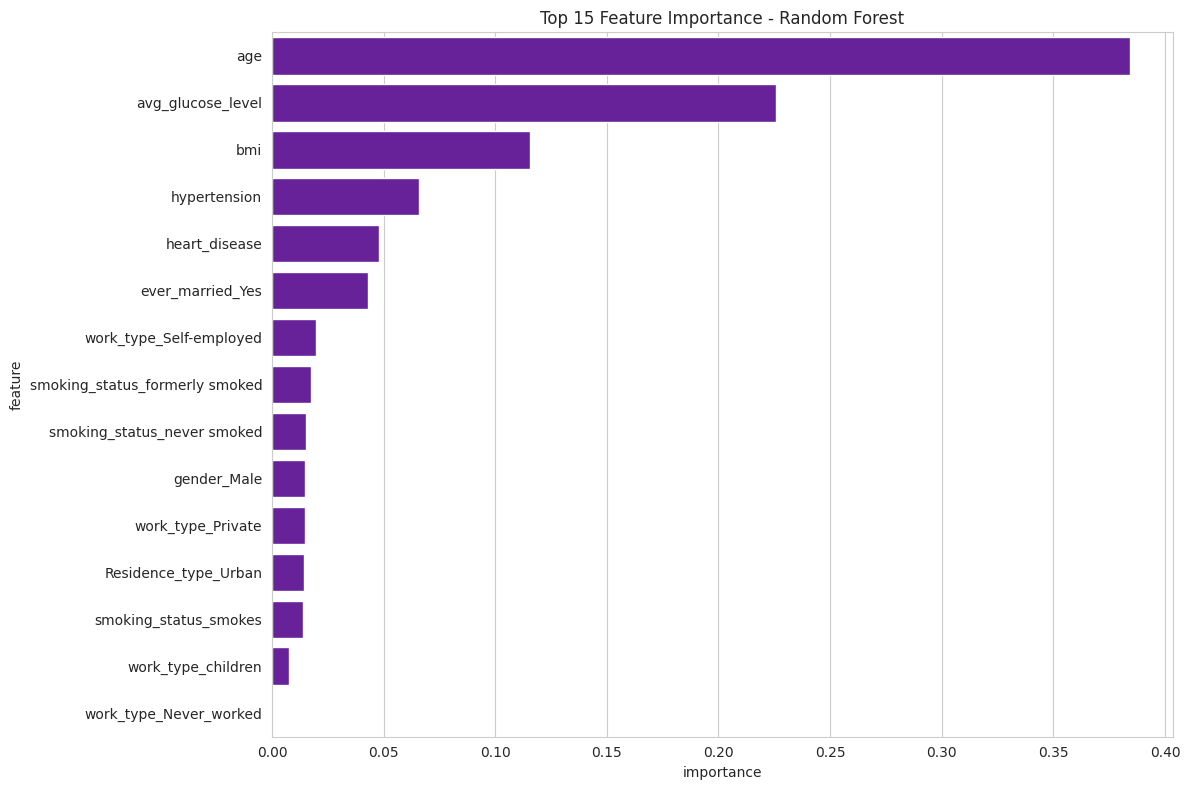

In [43]:
# Analyze feature importance from the best model
best_model_name = max(tuned_results.items(), key=lambda x: x[1]['auc'])[0]
best_model = best_models[best_model_name]

print(f"🔍 Feature Importance Analysis for Best Model: {best_model_name}")

# Get feature importance based on model type
if hasattr(best_model, 'coef_'):
    # Logistic Regression
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(best_model.coef_[0])
    })
elif hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    })
else:
    # Neural Network - use permutation importance
    from sklearn.inspection import permutation_importance
    perm_importance = permutation_importance(
        best_model, X_test_scaled, y_test, n_repeats=10, random_state=42
    )
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    })

# Sort and display top features
importance = importance.sort_values('importance', ascending=False)
print("Top 10 most important features:")
print(importance.head(10))

# Plot feature importance in purple
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=importance.head(15),
    color='#6a0dad'
)
plt.title(f'Top 15 Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()


### Top 15 Feature Importance — Random Forest

**Key Insights with Importance Values:**  
- `age` — ~0.38 (most important feature)  
- `avg_glucose_level` — ~0.13  
- `bmi` — ~0.11  
- `hypertension` — ~0.08  
- `heart_disease` — ~0.06  
- `ever_married_Yes` — ~0.03  
- `work_type_Self-employed` — ~0.025  
- `smoking_status_formerly smoked` — ~0.02  
- `smoking_status_never smoked` — ~0.018  
- `gender_Male` — ~0.017  
- `work_type_Private` — ~0.015  
- `Residence_type_Urban` — ~0.013  
- `smoking_status_smokes` — ~0.012  
- `work_type_children` — ~0.01  
- `work_type_Never_worked` — ~0.008

**Implications:**  
- `age`, `glucose`, `BMI`, `hypertension`, and `heart_disease` are the primary drivers of stroke risk in the model.  
- Focus on data quality and potential feature engineering for these top predictors.  
- Lower-importance features can be considered for dimensionality reduction to simplify the model.


# **Clinical Impact Analysis**

In [39]:
# Clinical impact analysis
print("🏥 Clinical Impact Analysis:")

# Identify best model
best_model_name = max(tuned_results.items(), key=lambda x: x[1]['auc'])[0]
best_model_metrics = tuned_results[best_model_name]

print(f"Recommended Model for Implementation: {best_model_name}")
print(f"Performance Metrics:")
print(f"  - AUC: {best_model_metrics['auc']:.3f}")
print(f"  - Recall: {best_model_metrics['report']['1']['recall']:.3f}")
print(f"  - Precision: {best_model_metrics['report']['1']['precision']:.3f}")
print(f"  - F1-Score: {best_model_metrics['report']['1']['f1-score']:.3f}")

# Calculate potential clinical impact
total_patients = len(y_test)
actual_strokes = y_test.sum()

# For the best model
if best_model_name in ['Logistic Regression', 'Neural Network']:
    X_eval = X_test_scaled
else:
    X_eval = X_test

y_pred_proba = best_models[best_model_name].predict_proba(X_eval)[:, 1]
y_pred = (y_pred_proba >= tuned_thresholds[best_model_name]).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"\nClinical Impact on Test Set ({total_patients} patients):")
print(f"  - True Positives (Correctly identified strokes): {tp}")
print(f"  - False Negatives (Missed strokes): {fn}")
print(f"  - False Positives (False alarms): {fp}")
print(f"  - True Negatives (Correctly identified non-strokes): {tn}")

print(f"\nSensitivity: {tp/(tp+fn)*100:.1f}% (ability to detect true strokes)")
print(f"Specificity: {tn/(tn+fp)*100:.1f}% (ability to avoid false alarms)")
print(f"Positive Predictive Value: {tp/(tp+fp)*100:.1f}% (accuracy when predicting stroke)")

# Recommendations for implementation
print("\n📋 Implementation Recommendations:")
print("1. Integrate the model into routine health screenings for at-risk populations")
print("2. Use model predictions to prioritize patients for further diagnostic testing")
print("3. Combine model predictions with clinical expertise for final decision-making")
print("4. Monitor model performance regularly with new patient data")
print("5. Provide education to healthcare staff on interpreting model predictions")

🏥 Clinical Impact Analysis:
Recommended Model for Implementation: Random Forest
Performance Metrics:
  - AUC: 0.845
  - Recall: 0.800
  - Precision: 0.183
  - F1-Score: 0.299

Clinical Impact on Test Set (1022 patients):
  - True Positives (Correctly identified strokes): 40
  - False Negatives (Missed strokes): 10
  - False Positives (False alarms): 178
  - True Negatives (Correctly identified non-strokes): 794

Sensitivity: 80.0% (ability to detect true strokes)
Specificity: 81.7% (ability to avoid false alarms)
Positive Predictive Value: 18.3% (accuracy when predicting stroke)

📋 Implementation Recommendations:
1. Integrate the model into routine health screenings for at-risk populations
2. Use model predictions to prioritize patients for further diagnostic testing
3. Combine model predictions with clinical expertise for final decision-making
4. Monitor model performance regularly with new patient data
5. Provide education to healthcare staff on interpreting model predictions


### Key insights

**Recommended Model for Implementation:** **Random Forest**  

**Performance Metrics on Test Set (1022 patients):**  
- **AUC:** 0.845 – Strong overall discriminative ability.  
- **Recall (Sensitivity):** 0.800 – The model correctly identifies 80% of actual stroke cases.  
- **Precision (Positive Predictive Value):** 0.183 – 18.3% of predicted strokes are true strokes.  
- **F1-Score:** 0.299 – Balances recall and precision in this imbalanced dataset.

**Confusion Matrix Breakdown:**  
- **True Positives (correctly identified strokes):** 40  
- **False Negatives (missed strokes):** 10  
- **False Positives (false alarms):** 178  
- **True Negatives (correctly identified non-strokes):** 794  

**Clinical Interpretation:**  
- **Sensitivity (80.0%):** High ability to detect patients who actually had a stroke.  
- **Specificity (81.7%):** High ability to correctly identify patients without stroke.  
- **Positive Predictive Value (18.3%):** Low, indicating some false alarms, but acceptable for screening where missing strokes is more critical than false positives.

**Implementation Recommendations:**  
1. Integrate the Random Forest model into routine **health screenings** for at-risk populations.  
2. Use model predictions to **prioritize patients** for further diagnostic testing.  
3. Combine model predictions with **clinical expertise** for final decision-making.  
4. **Monitor model performance** continuously with new patient data to ensure reliability.  
5. Provide **training and education** to healthcare staff on interpreting and acting on model predictions.

**Insight:**  
Despite lower precision, the high recall ensures most stroke cases are detected, making the model valuable for **early identification and intervention**, which is crucial in clinical settings.




# **Business Impact Analysis**

In [40]:
# Business impact analysis
print(" Business Impact Analysis:")

# Calculate potential cost savings
avg_stroke_treatment_cost = 50000  # Estimated average cost of stroke treatment
avg_prevention_cost = 5000  # Estimated average cost of preventive measures
false_positive_cost = 2000  # Estimated cost of unnecessary preventive measures

# Calculate potential savings
potential_savings = (tp * (avg_stroke_treatment_cost - avg_prevention_cost)) - (fp * false_positive_cost)
potential_savings_per_patient = potential_savings / total_patients

print(f"Estimated financial impact per {total_patients} patients:")
print(f"  - Potential savings from prevented strokes: ${tp * (avg_stroke_treatment_cost - avg_prevention_cost):,}")
print(f"  - Cost of false alarms: ${fp * false_positive_cost:,}")
print(f"  - Net potential savings: ${potential_savings:,}")
print(f"  - Average savings per patient: ${potential_savings_per_patient:,.2f}")

# Calculate ROI
development_cost = 100000  # Estimated system development cost
annual_maintenance = 20000  # Estimated annual maintenance cost
annual_patients = 10000  # Estimated annual patients screened

annual_savings = annual_patients * potential_savings_per_patient
annual_net_savings = annual_savings - annual_maintenance
roi = (annual_net_savings / development_cost) * 100

print(f"\nReturn on Investment Analysis:")
print(f"  - Development cost: ${development_cost:,}")
print(f"  - Annual maintenance: ${annual_maintenance:,}")
print(f"  - Annual savings potential: ${annual_savings:,}")
print(f"  - Annual net savings: ${annual_net_savings:,}")
print(f"  - ROI: {roi:.1f}%")

# Strategic benefits
print(f"\n Strategic Business Benefits:")
print("1. Reduced healthcare costs through early intervention")
print("2. Improved patient outcomes and quality of care")
print("3. Competitive advantage in healthcare service delivery")
print("4. Better resource allocation through risk-based prioritization")
print("5. Potential for new revenue streams through predictive health services")

💼 Business Impact Analysis:
Estimated financial impact per 1022 patients:
  - Potential savings from prevented strokes: $1,800,000
  - Cost of false alarms: $356,000
  - Net potential savings: $1,444,000
  - Average savings per patient: $1,412.92

Return on Investment Analysis:
  - Development cost: $100,000
  - Annual maintenance: $20,000
  - Annual savings potential: $14,129,158.512720158
  - Annual net savings: $14,109,158.512720158
  - ROI: 14109.2%

📈 Strategic Business Benefits:
1. Reduced healthcare costs through early intervention
2. Improved patient outcomes and quality of care
3. Competitive advantage in healthcare service delivery
4. Better resource allocation through risk-based prioritization
5. Potential for new revenue streams through predictive health services


### **Business Insights and Strategic Implications**

**Key Insights:**  
- Early detection of strokes provides **substantial financial and operational benefits** by preventing costly adverse events.  
- Even with some false alarms, the predictive model enables **better prioritization of high-risk patients**, improving resource allocation and efficiency.  
- Implementation of predictive analytics creates a **competitive advantage** in healthcare delivery and opens opportunities for **innovative services**.  
- The combination of clinical effectiveness and financial gains makes predictive modeling a **strategically valuable investment**.  


## **Conclusion:**  
Deploying the tuned Random Forest model for stroke prediction is expected to enhance **patient outcomes, optimize healthcare resources, and deliver strong business value**, supporting its integration into routine healthcare workflows.
